In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

2025-02-16 00:41:52.027481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import re

In [3]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [4]:
datapath = "../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [5]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [6]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [7]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [8]:
dfs = []

In [9]:
for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs.append(df)

100%|█████████████████████████████████████████| 746/746 [00:22<00:00, 32.51it/s]


In [10]:
features = pd.concat(dfs, ignore_index=True)
print ("shape : ", features.shape)
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
print ("columns :", end=' ')
print (sensor_columns)

print ()
features = pd.concat(dfs, ignore_index=True)
print("Columns after concat:", features.columns)
print("\nActivity distribution :", features['activity'].value_counts())

shape :  (214514, 42)
columns : ['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z', 'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z', 'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x', 'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y', 'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z', 'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z']

Columns after concat: Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 

In [11]:
features['activity'] = features['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
print("\nActivity distribution :", features['activity'].value_counts())


Activity distribution : activity
0    153489
1     61025
Name: count, dtype: int64


In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214514 entries, 0 to 214513
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rightpocket_acc_x  214514 non-null  float64
 1   rightpocket_acc_y  214514 non-null  float64
 2   rightpocket_acc_z  214514 non-null  float64
 3   chest_acc_x        214237 non-null  float64
 4   chest_acc_y        214237 non-null  float64
 5   chest_acc_z        214237 non-null  float64
 6   chest_gyro_x       214237 non-null  float64
 7   chest_gyro_y       214237 non-null  float64
 8   chest_gyro_z       214237 non-null  float64
 9   chest_mag_x        214237 non-null  float64
 10  chest_mag_y        214237 non-null  float64
 11  chest_mag_z        214237 non-null  float64
 12  wrist_acc_x        214514 non-null  float64
 13  wrist_acc_y        214514 non-null  float64
 14  wrist_acc_z        214514 non-null  float64
 15  wrist_gyro_x       214514 non-null  float64
 16  wr

In [13]:
features = features.dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151986 entries, 0 to 214217
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rightpocket_acc_x  151986 non-null  float64
 1   rightpocket_acc_y  151986 non-null  float64
 2   rightpocket_acc_z  151986 non-null  float64
 3   chest_acc_x        151986 non-null  float64
 4   chest_acc_y        151986 non-null  float64
 5   chest_acc_z        151986 non-null  float64
 6   chest_gyro_x       151986 non-null  float64
 7   chest_gyro_y       151986 non-null  float64
 8   chest_gyro_z       151986 non-null  float64
 9   chest_mag_x        151986 non-null  float64
 10  chest_mag_y        151986 non-null  float64
 11  chest_mag_z        151986 non-null  float64
 12  wrist_acc_x        151986 non-null  float64
 13  wrist_acc_y        151986 non-null  float64
 14  wrist_acc_z        151986 non-null  float64
 15  wrist_gyro_x       151986 non-null  float64
 16  wrist_g

In [14]:
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]

scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])

features_scaled = features_scaled[sensor_columns + ['activity']]
features_scaled.columns

Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')

In [15]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [16]:
adl_count = features_scaled['activity'].value_counts()[0]
fall_count = features_scaled['activity'].value_counts()[1]

adl_mask = features_scaled['activity'] == 0
adl_data = features_scaled[adl_mask]
adl1 = adl_data.iloc[:int(adl_count * 0.8)]    # 80% for training
adl2 = adl_data.iloc[int(adl_count * 0.2):]    # 20% for testing

fall_mask = features_scaled['activity'] == 1
fall_data = features_scaled[fall_mask]
fall1 = fall_data.iloc[:int(fall_count * 0.8)]  # 80% for testing
fall2 = fall_data.iloc[int(fall_count * 0.2):]  # 20% for testing

print(f"ADL1 (train) shape: {adl1.shape}")
print(f"ADL2 (test) shape: {adl2.shape}")
print(f"Fall1 (test) shape: {fall1.shape}")
print(f"Fall2 (test) shape: {fall2.shape}")

ADL1 (train) shape: (89308, 40)
ADL2 (test) shape: (89309, 40)
Fall1 (test) shape: (32280, 40)
Fall2 (test) shape: (32280, 40)


In [17]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)

test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)

test_data = np.concatenate([test_adl_data, test_fall1_data, test_fall2_data])
test_labels = np.concatenate([test_adl_labels, test_fall1_labels, test_fall2_labels])

print(f"Train data: {train_data.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Test data: {test_data.shape}")
print(f"Test labels: {test_labels.shape}")

Train data: (4464, 40, 39)
Train labels: (4464,)
Test data: (7690, 40, 39)
Test labels: (7690,)


-----

In [18]:
# Input:      (40, 39)
# Level 1:    (20, 64)   # spatial ↓2, channels ↑
# Level 2:    (10, 128)  # spatial ↓2, channels ↑
# Level 3:    (5, 256)   # spatial ↓2, channels ↑
# Bottleneck: (5, 512)   
# Level 3:    (10, 256)  # spatial ↑2, channels ↓
# Level 2:    (20, 128)  # spatial ↑2, channels ↓
# Level 1:    (40, 64)   # spatial ↑2, channels ↓
# Output:     (40, 39)

In [19]:
class DoubleConv(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DoubleConv, self).__init__()
        self.conv1 = tf.keras.layers.Conv1D(filters, 3, padding='same')  
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters, 3, padding='same') 
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.gelu = tf.keras.activations.gelu
        self.dropout = tf.keras.layers.Dropout(0.05)
    
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.gelu(x)
        x = self.dropout(x, training=training)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.gelu(x)
        x = self.dropout(x, training=training)
        return x

In [20]:
class UNetDiffusion(tf.keras.Model):
    def __init__(self):
        super(UNetDiffusion, self).__init__()
        
        # Input: (40, 39)
        self.enc1 = tf.keras.Sequential([
            DoubleConv(48),  
            tf.keras.layers.MaxPooling1D(2)  # (20, 48)
        ])
        
        self.enc2 = tf.keras.Sequential([
            DoubleConv(96), 
            tf.keras.layers.MaxPooling1D(2)  # (10, 96)
        ])
        
        # Bottleneck
        self.bottleneck = DoubleConv(192)  # (10, 192)
        
        # Decoder part
        self.dec2 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),  
            DoubleConv(96)  # (20, 96)
        ])
        
        self.dec1 = tf.keras.Sequential([
            tf.keras.layers.UpSampling1D(2),  
            DoubleConv(48)  # (40, 48)
        ])
        
        # Final convolution
        self.final = tf.keras.layers.Conv1D(39, 1, padding='same')  # (40, 39)
        
    def call(self, x, training=False):
        # Encoder
        enc1_before_pool = x  # (40, 39)
        enc1_output = self.enc1(x, training=training)  # (20, 48)
        
        enc2_before_pool = enc1_output  # (20, 48)
        enc2_output = self.enc2(enc1_output, training=training)  # (10, 96)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc2_output, training=training)  # (10, 192)
        
        # Decoder with skip connections
        dec2_output = self.dec2(bottleneck, training=training)  # (20, 96)
        dec2_output = tf.concat([enc2_before_pool, dec2_output], axis=-1)  # (20, 48+96=144)
        
        dec1_output = self.dec1(dec2_output, training=training)  # (40, 48)
        dec1_output = tf.concat([enc1_before_pool, dec1_output], axis=-1)  # (40, 39+48=87)
        
        output = self.final(dec1_output)  # (40, 39)
        
        return output

In [21]:
def forward_diffusion(x, noise_level=0.05):  
    dtype = x.dtype
    noise = tf.random.normal(shape=tf.shape(x), dtype=dtype) * noise_level
    return x + noise

def anomaly_score(x_real, x_recon):
    return tf.reduce_mean(tf.abs(x_real - x_recon), axis=1)

In [22]:
BATCH_SIZE = 32
EPOCHS = 50
INITIAL_LEARNING_RATE = 1e-3 
DECAY_STEPS = 1000           # 500 -> 1000
DECAY_RATE = 0.98           # 0.95 -> 0.98

In [23]:
model = UNetDiffusion()
optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        INITIAL_LEARNING_RATE, DECAY_STEPS, DECAY_RATE
    )
)

In [24]:
from tqdm.auto import tqdm

train_dataset = tf.data.Dataset.from_tensor_slices(train_data.astype('float32'))
train_dataset = train_dataset.batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    train_loss = 0
    n_batches = len(train_data) // BATCH_SIZE
    
    pbar = tqdm(enumerate(train_dataset), 
                desc=f'Epoch {epoch+1}/{EPOCHS}', 
                total=n_batches,
                leave=False)
    
    for i, batch_data in pbar:        
        with tf.GradientTape() as tape:
            noisy = forward_diffusion(batch_data, noise_level=0.1)
            reconstructed = model(noisy, training=True)
            loss = tf.reduce_mean(tf.square(reconstructed - batch_data))
        
        grads = tape.gradient(loss, model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=0.5)  # clip_norm 1.0 -> 0.5
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        train_loss += loss.numpy()
        pbar.set_postfix({'Loss': f'{loss.numpy():.4f}'})
    
    avg_loss = train_loss / n_batches
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}')

Epoch 1/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 1.1057


2025-02-16 00:43:25.338964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2/50 - Loss: 0.5703


2025-02-16 00:44:19.705671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3/50 - Loss: 0.3652


2025-02-16 00:45:20.337848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4/50 - Loss: 0.2574


2025-02-16 00:46:11.383797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5/50 - Loss: 0.1888


2025-02-16 00:46:57.128737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 6/50 - Loss: 0.1429


2025-02-16 00:47:39.939414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 7/50 - Loss: 0.1106


2025-02-16 00:48:22.883222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 8/50 - Loss: 0.0865


2025-02-16 00:49:05.134430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 9/50 - Loss: 0.0688


2025-02-16 00:49:47.551682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 10/50 - Loss: 0.0548


2025-02-16 00:50:30.299000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 11/50 - Loss: 0.0447


2025-02-16 00:51:13.126990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 12/50 - Loss: 0.0367


2025-02-16 00:51:55.777924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 13/50 - Loss: 0.0309


2025-02-16 00:52:38.695931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 14/50 - Loss: 0.0259


2025-02-16 00:53:21.550175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 15/50 - Loss: 0.0222


2025-02-16 00:54:04.068149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 16/50 - Loss: 0.0196


2025-02-16 00:54:46.415367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 17/50 - Loss: 0.0175


2025-02-16 00:55:29.015477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 18/50 - Loss: 0.0157


2025-02-16 00:56:11.543658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 19/50 - Loss: 0.0144


2025-02-16 00:56:53.717791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 20/50 - Loss: 0.0134


2025-02-16 00:57:36.054398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 21/50 - Loss: 0.0126


2025-02-16 00:58:18.939304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 22/50 - Loss: 0.0120


2025-02-16 00:59:01.574522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 23/50 - Loss: 0.0115


2025-02-16 00:59:44.820055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 24/50 - Loss: 0.0112


2025-02-16 01:00:27.884344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 25/50 - Loss: 0.0109


2025-02-16 01:01:10.874575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 26/50 - Loss: 0.0106


2025-02-16 01:01:53.494744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 27/50 - Loss: 0.0105


2025-02-16 01:02:36.582403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 28/50 - Loss: 0.0103


2025-02-16 01:03:19.723603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 29/50 - Loss: 0.0102


2025-02-16 01:04:02.583877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 30/50 - Loss: 0.0101


2025-02-16 01:04:45.544089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 31/50 - Loss: 0.0101


2025-02-16 01:05:28.634813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 32/50 - Loss: 0.0100


2025-02-16 01:06:11.717116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 33/50 - Loss: 0.0100


2025-02-16 01:06:54.570716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 34/50 - Loss: 0.0100


2025-02-16 01:07:37.460698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 35/50 - Loss: 0.0099


2025-02-16 01:08:20.479654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 36/50 - Loss: 0.0099


2025-02-16 01:09:03.272509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 37/50 - Loss: 0.0099


2025-02-16 01:09:46.191339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 38/50 - Loss: 0.0099


2025-02-16 01:10:28.840099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 39/50 - Loss: 0.0099


2025-02-16 01:11:11.490654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 40/50 - Loss: 0.0099


2025-02-16 01:11:54.176392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 41/50 - Loss: 0.0099


2025-02-16 01:12:36.715028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 42/50 - Loss: 0.0099


2025-02-16 01:13:19.352528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 43/50 - Loss: 0.0099


2025-02-16 01:14:03.432360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 44/50 - Loss: 0.0099


2025-02-16 01:14:47.176125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 45/50 - Loss: 0.0099


2025-02-16 01:15:29.878762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 46/50 - Loss: 0.0099


2025-02-16 01:16:12.911793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 47/50 - Loss: 0.0099


2025-02-16 01:16:55.428228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 48/50 - Loss: 0.0099


2025-02-16 01:17:38.403274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 49/50 - Loss: 0.0099


2025-02-16 01:18:20.940926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 50/50:   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 50/50 - Loss: 0.0099


2025-02-16 01:19:03.459042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [35]:
from sklearn.metrics import mean_squared_error

valid_x_predictions = model.predict(test_data)
error = flatten(test_data) - flatten(valid_x_predictions)

valid_mse = np.mean(np.power(flatten(test_data) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({
    'reconstruction_error': valid_mse,
    'true_class': test_labels
})

error_df

241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


,reconstruction_error,true_class
0,0.000087,0.0
1,0.000076,0.0
2,0.000124,0.0
3,0.000113,0.0
4,0.000140,0.0
...,...,...
7685,0.000232,1.0
7686,0.000226,1.0
7687,0.000248,1.0
7688,0.000226,1.0


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


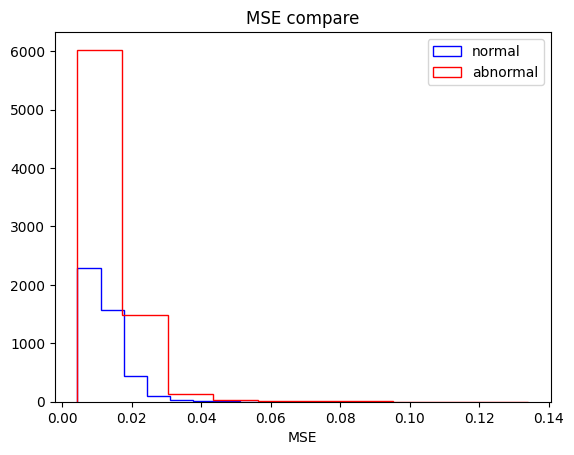

In [36]:
X_pred_train = model.predict(train_data)
scored_train = np.mean(np.abs(flatten(train_data) - flatten(X_pred_train)), axis=1)
X_pred_test = model.predict(test_data)
scored_test = np.mean(np.abs(flatten(test_data) - flatten(X_pred_test)), axis=1)

plt.title('MSE compare') 
plt.hist(scored_train, bins=10, color='blue', histtype='step', label='normal') 
plt.hist(scored_test, bins=10, color='red', histtype='step', label='abnormal') 
plt.xlabel('MSE')
plt.legend()
plt.show()

In [37]:
error_df['true_class'].value_counts()

true_class
0.0    4464
1.0    3226
Name: count, dtype: int64

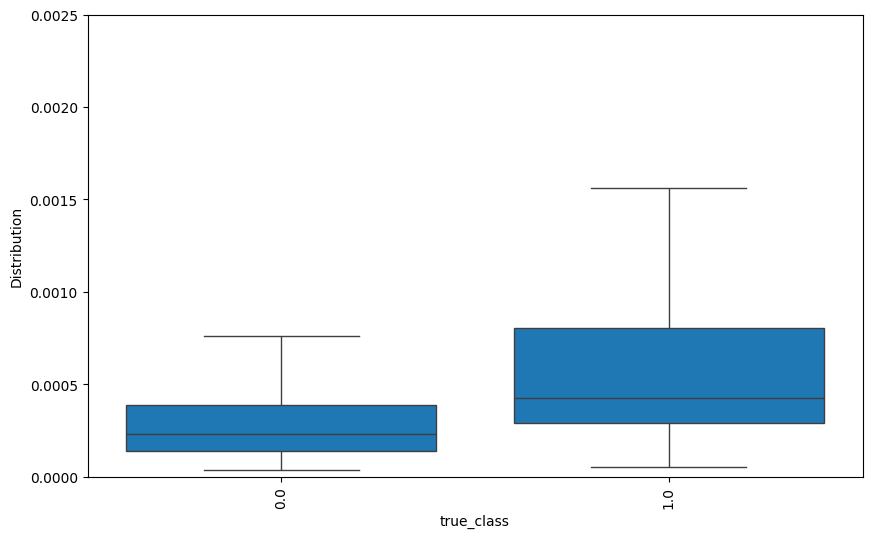

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False, saturation=1)
plt.ylabel('Distribution')

plt.ylim((0, 0.0025))
plt.xticks(rotation=90)
plt.show()

In [53]:
threshold = 0.0005

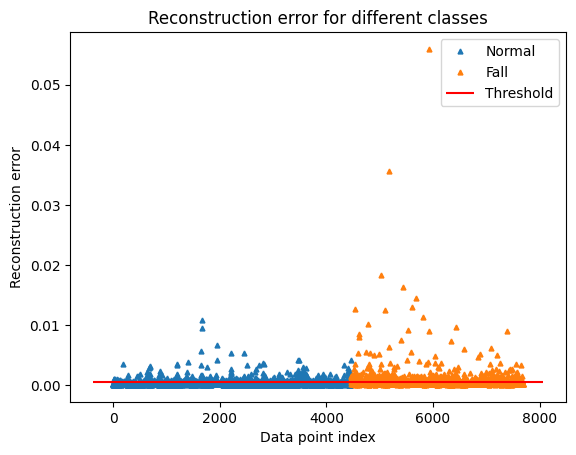

In [54]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

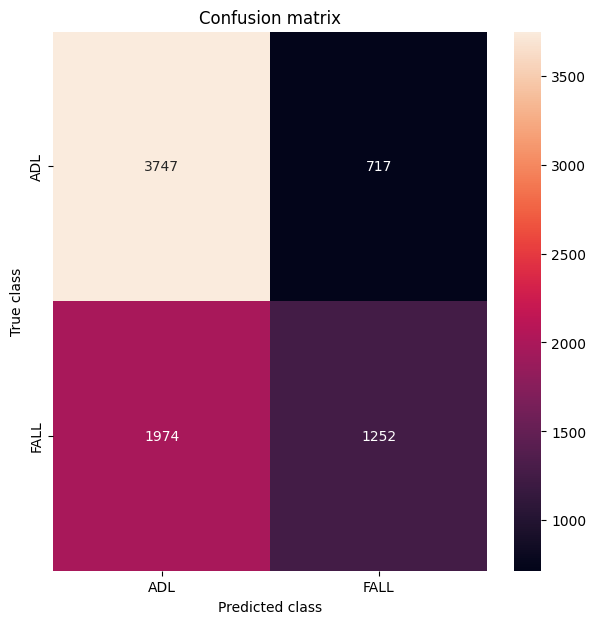

In [55]:
LABELS = ["ADL", "FALL"]

plt.figure(figsize=(7, 7))
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [56]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(error_df.true_class, y_pred, average='binary')
accuracy = accuracy_score(error_df.true_class, y_pred)

print('\nPerformance Metrics:')
print(f'Accuracy Score : {accuracy:.4f}')
print(f'Precision     : {precision:.4f}')
print(f'Recall        : {recall:.4f}')
print(f'F1 Score      : {f1:.4f}')


Performance Metrics:
Accuracy Score : 0.6501
Precision     : 0.6359
Recall        : 0.3881
F1 Score      : 0.4820
